In [53]:
#APY Simulation
import math
from matplotlib import pyplot as plt
import numpy as np

In [54]:
# constant values for premium the pricing formula

# user inputs 
DURATION = 1
PROTECTION_AMOUNT = 1

# predefined values
CURVATURE = 1/20
LEVERAGE_RATIO_FLOOR = 0.1
LEVERAGE_RATIO_CEILING = 0.2
BUFFER = 0.05
LEVERAGE_RATIO_MIN = LEVERAGE_RATIO_FLOOR - BUFFER
LEVERAGE_RATIO_MAX = LEVERAGE_RATIO_CEILING + BUFFER
MIN_CARAPACE_RISK_PREMIUM = 0.02
UNDERLYING_RISK_PREMIUM_PERCENT = 0.1
PROTECTION_BUYER_APY = 0.2
MINIMUM_STOKEN_UNDERLYING = 400000
MINIMUM_TOTAL_PROTECTION_AMOUNT = 2000000

# market driven values
LEVERAGE_RATIO = 0.15

# flags
INSUFFICIENT_TOTAL_CAPITAL = -1
INSUFFICIENT_TOTAL_PROTECTION_AMOUNT = -2


In [55]:
# the leverage ratio formula

# When the Carapace Protocol starts a new pool, there are the minimal sToken underlying from protection sellers and the minimal total protection amount in the pool. If the sToken underlying is less than the minimum sToken underlying or the total protection amount is less than minimum total protection amount, the premium is min_base_premium + risk_premium. 

def leverage_ratio(
    sToken_underlying=MINIMUM_STOKEN_UNDERLYING,
    total_protection_amount=MINIMUM_TOTAL_PROTECTION_AMOUNT
):
    if(sToken_underlying < MINIMUM_STOKEN_UNDERLYING):
        return INSUFFICIENT_TOTAL_CAPITAL
    if(total_protection_amount < MINIMUM_TOTAL_PROTECTION_AMOUNT):
        return INSUFFICIENT_TOTAL_PROTECTION_AMOUNT
    return sToken_underlying/total_protection_amount
    # where sToken_underlying = locked_capital + accrued_premiums - default_payouts

# base premium formula

def carapace_risk_premium(
    duration=DURATION,
    curvature=CURVATURE,
    leverage_ratio=LEVERAGE_RATIO,
    leverage_ratio_min=LEVERAGE_RATIO_MIN,
    leverage_ratio_max=LEVERAGE_RATIO_MAX,
    min_carapace_risk_premium= MIN_CARAPACE_RISK_PREMIUM,
):

    if(leverage_ratio == INSUFFICIENT_TOTAL_CAPITAL):
        #print("total capital is less than minimum total capital")
        return min_carapace_risk_premium 
    if(leverage_ratio == INSUFFICIENT_TOTAL_PROTECTION_AMOUNT):
        #print("total protection amount is less than minimum total protection amount")
        return min_carapace_risk_premium 
    risk_factor = ((leverage_ratio_max - leverage_ratio) /
                   (leverage_ratio-leverage_ratio_min)) * curvature
    carapace_risk_premium = max((1-pow(math.e, -duration * risk_factor)), min_carapace_risk_premium) 
    return carapace_risk_premium

# risk premium formula
def underlying_risk_premium(
    duration=DURATION,
    underlying_risk_premium_percent=UNDERLYING_RISK_PREMIUM_PERCENT,
    protection_buyer_apy=PROTECTION_BUYER_APY,
):
    underlying_risk_premium = underlying_risk_premium_percent * duration * protection_buyer_apy
    return underlying_risk_premium

# premium formula
def premium(
    protection_amount=PROTECTION_AMOUNT,
    duration=DURATION,
    curvature=CURVATURE,
    leverage_ratio=LEVERAGE_RATIO,
    underlying_risk_premium_percent=UNDERLYING_RISK_PREMIUM_PERCENT,
    protection_buyer_apy=PROTECTION_BUYER_APY,
    leverage_ratio_min=LEVERAGE_RATIO_MIN,
    leverage_ratio_max=LEVERAGE_RATIO_MAX,
    min_carapace_risk_premium= MIN_CARAPACE_RISK_PREMIUM,
):

    Carapace_risk_premium = carapace_risk_premium(
        duration=duration,
        curvature=curvature,
        leverage_ratio=leverage_ratio,
        leverage_ratio_min=leverage_ratio_min,
        leverage_ratio_max=leverage_ratio_max,
        min_carapace_risk_premium= min_carapace_risk_premium,
    )

    Underlying_risk_premium = underlying_risk_premium(
        duration=DURATION,
        underlying_risk_premium_percent=underlying_risk_premium_percent,
        protection_buyer_apy=protection_buyer_apy,
    )

    premium = (Carapace_risk_premium + Underlying_risk_premium) * protection_amount
    return premium


In [56]:
#scenario 1
#Day 0, 10 sellers deposited 100k each, 10 buyers bought protection for 1M each for 1 year at 4% interest and no protocol fees
#seller APY at day 365 assuming no default and no seller withdrawal
total_sTokens = 1000000
total_capital = 1000000
accrued_premium = 400000
exchange_rate_day_0 = total_capital/total_sTokens
exchange_rate_day_365 = (total_capital + accrued_premium)/total_sTokens
exchange_rate_change_percent = accrued_premium/total_capital
print("seller APY", exchange_rate_change_percent*100, "%")

seller APY 40.0 %


In [57]:
premium()

0.06877057549928599

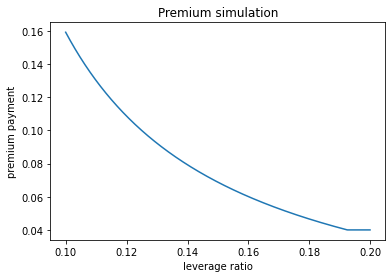

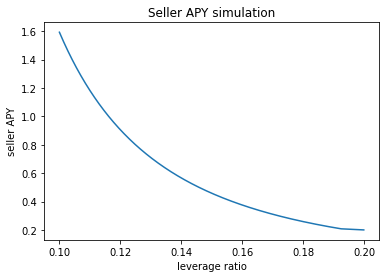

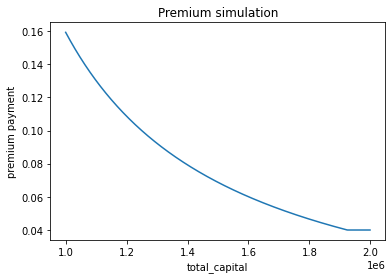

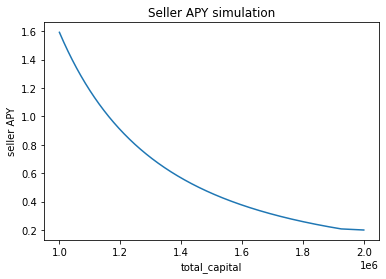

In [59]:
#scenario 2
#Day 0, 10 buyers bought protection for 1M each for 1 year and no protocol fees
#total_capital ranges between 1M and 2M so that leverage_ratio varies between 0.1 and 0.2
#seller APY at day 365 assuming no default and no seller withdrawal
#entire premium is accrued
#exchange_rate_change_percent = accrued_premium/total_capital
#exchange_rate_change_percent = premium_per_unit * total_protection_amount/total_capital
#exchange_rate_change_percent = premium_per_unit / leverage_ratio

# Seller APY simulation with leverage_ratios
# setting the x - coordinates with the leverage_ratios
total_protection_amount = 10000000
total_capitals = np.arange(1000000, 2000000 , 1000)
leverage_ratios = [total_capital/total_protection_amount for total_capital in total_capitals]
premiums = [premium(leverage_ratio=leverage_ratio) 
            for leverage_ratio in leverage_ratios]

plt.plot(leverage_ratios, premiums)
plt.title("Premium simulation")
plt.xlabel("leverage ratio")
plt.ylabel("premium payment")
plt.show()
seller_apys = [premium(leverage_ratio=leverage_ratio) / leverage_ratio
            for leverage_ratio in leverage_ratios]

plt.plot(leverage_ratios, seller_apys)
plt.title("Seller APY simulation")
plt.xlabel("leverage ratio")
plt.ylabel("seller APY")
plt.show()

plt.plot(total_capitals, premiums)
plt.title("Premium simulation")
plt.xlabel("total_capital")
plt.ylabel("premium payment")
plt.show()

plt.plot(total_capitals, seller_apys)
plt.title("Seller APY simulation")
plt.xlabel("total_capital")
plt.ylabel("seller APY")
plt.show()


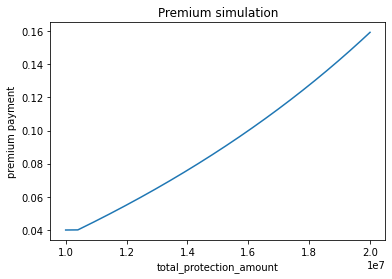

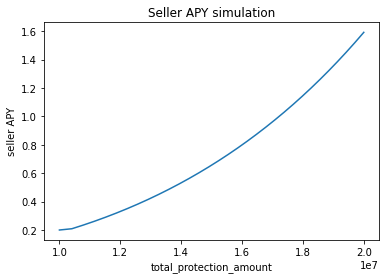

In [60]:
#scenario 3
#Day 0, sellers provide 2M capital 
#total_protection_amount ranges between 10M and 20M so that leverage_ratio varies between 0.1 and 0.2
#seller APY at day 365 assuming no default and no seller withdrawal
#entire premium is accrued
#exchange_rate_change_percent = accrued_premium/total_capital
#exchange_rate_change_percent = premium_per_unit * total_protection_amount/total_capital
#exchange_rate_change_percent = premium_per_unit / leverage_ratio

# Seller APY simulation with leverage_ratios
# setting the x - coordinates with the leverage_ratios
total_protection_amounts = np.arange(10000000, 20000000 , 1000)
total_capital = 2000000
leverage_ratios = [total_capital/total_protection_amount for total_protection_amount in total_protection_amounts]
premiums = [premium(leverage_ratio=leverage_ratio) 
            for leverage_ratio in leverage_ratios]

plt.plot(total_protection_amounts, premiums)
plt.title("Premium simulation")
plt.xlabel("total_protection_amount")
plt.ylabel("premium payment")
plt.show()
seller_apys = [premium(leverage_ratio=leverage_ratio) / leverage_ratio
            for leverage_ratio in leverage_ratios]

plt.plot(total_protection_amounts, seller_apys)
plt.title("Seller APY simulation")
plt.xlabel("total_protection_amount")
plt.ylabel("seller APY")
plt.show()


0.06877057549928599


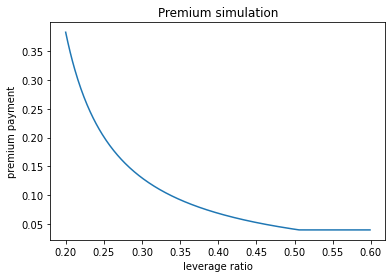

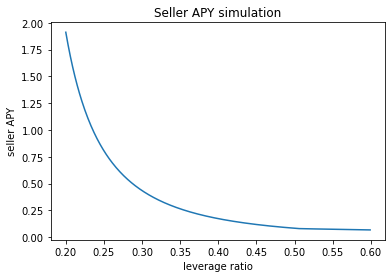

In [61]:
#scenario 4
#Day 0, 10 buyers bought protection for 1M each for 1 year and no protocol fees
#total_capital ranges between 1M and 2M so that leverage_ratio varies between 0.2 and 0.6
#seller APY at day 365 assuming no default and no seller withdrawal
#entire premium is accrued
#exchange_rate_change_percent = accrued_premium/total_capital
#exchange_rate_change_percent = premium_per_unit * total_protection_amount/total_capital
#exchange_rate_change_percent = premium_per_unit / leverage_ratio

# Seller APY simulation with leverage_ratios
# setting the x - coordinates with the leverage_ratios
leverage_ratios = np.arange(0.2, 0.6, 0.001)
print(premium())
premiums = [premium(leverage_ratio=leverage_ratio, leverage_ratio_min = 0.15, leverage_ratio_max =0.65) 
            for leverage_ratio in leverage_ratios]

plt.plot(leverage_ratios, premiums)
plt.title("Premium simulation")
plt.xlabel("leverage ratio")
plt.ylabel("premium payment")
plt.show()
seller_apys = [premium(leverage_ratio=leverage_ratio, leverage_ratio_min = 0.15, leverage_ratio_max =0.65 ) / leverage_ratio
            for leverage_ratio in leverage_ratios]

plt.plot(leverage_ratios, seller_apys)
plt.title("Seller APY simulation")
plt.xlabel("leverage ratio")
plt.ylabel("seller APY")
plt.show()


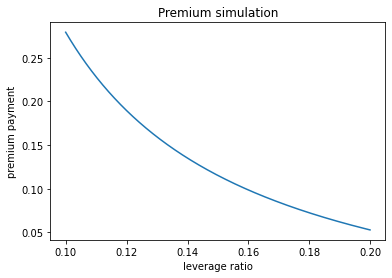

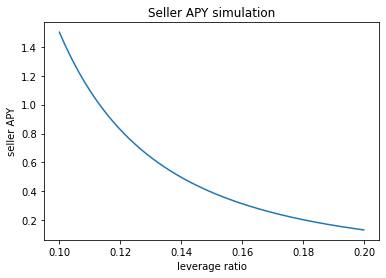

In [68]:
#scenario 5
#Day 0, 10 buyers bought protection for 1M each for 2 years and no protocol fees
#total_capital ranges between 1M and 2M so that leverage_ratio varies between 0.1 and 0.2
#seller APY at day 365 assuming no default and no seller withdrawal
#premium accrued for first 365 days will be responsible for seller APY
#exchange_rate_change_percent = accrued_premium/total_capital
#exchange_rate_change_percent = premium_per_unit * total_protection_amount/total_capital
#exchange_rate_change_percent = premium_per_unit / leverage_ratio

# Seller APY simulation with leverage_ratios
# setting the x - coordinates with the leverage_ratios
total_protection_amount = 10000000
total_capitals = np.arange(1000000, 2000000 , 1000)
total_duration = 2
leverage_ratio_max = LEVERAGE_RATIO_MAX
leverage_ratio_min = LEVERAGE_RATIO_MIN
curvature = CURVATURE
duration = 1
leverage_ratios = [total_capital/total_protection_amount for total_capital in total_capitals]
premiums = [premium(leverage_ratio=leverage_ratio, duration = total_duration) 
            for leverage_ratio in leverage_ratios]

plt.plot(leverage_ratios, premiums)
plt.title("Premium simulation")
plt.xlabel("leverage ratio")
plt.ylabel("premium payment")
plt.show()

risk_factors = [((leverage_ratio_max - leverage_ratio) /
                   (leverage_ratio-leverage_ratio_min)) * curvature for leverage_ratio in leverage_ratios]

seller_apys = []
for index in range(len(leverage_ratios)):
    accrued_premium_constant = premiums[index]/(1- (math.e ** (-total_duration * risk_factors[index]) ))
    accrued_premium = accrued_premium_constant * (1- (math.e ** (-duration * risk_factors[index]) ))
    seller_apys.append(accrued_premium/leverage_ratios[index])
    
plt.plot(leverage_ratios, seller_apys)
plt.title("Seller APY simulation")
plt.xlabel("leverage ratio")
plt.ylabel("seller APY")
plt.show()

In [73]:
#duration is in year
def annualized_percentage_yield(yield_per_unit, duration):
    return ((1+yield_per_unit)**(1/duration) - 1) * 100
    

In [75]:
print(annualized_percentage_yield(1,2))

41.42135623730952
